# Agent

## Properties
 - (Binary) Group Identity 
  - ["Group I", "Group Non-I"]
 - (Binary) Prejudice towards other group: 0 or 1
  - have Prejudice or Not
 - Accumulated interest level in the issue of the protest, $a_i \in [0, 1]$
  - it cant be greater than 1
 - State: 
  - ["Protest", "Non Protest"]
 - Physical position $x \in [0,1]$ and $y \in [0,1]$ 
  - can not be greater than 1
  - can not be smaller than 0
 - interest decay max value $d_i = 0.01$
  - different for each agent $\in [0, d_i]$
 - threshold to become protestor $\theta_i$
  - different for each agent
 
## Interaction Rule
 - if Prejudice == 0 and phsically close (euclidean distance closer than 0.05), 
  - Interaction: interest level increases for both $g_i = 10 \times d_i = 10 \times 0.01 = 0.1$
  
 - At each time tick, 
  - Interest level decreases with $d_i$
  - move within MOVEMENT_RADIUS = 0.01
 
 - if $a_i > \theta_i$
  - become protestor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

INTEREST_DECAY = 0.01
INTERACTION_RADIUS = 0.05
MOVEMENT_RADIUS = 0.01

class agent():
    def __init__(self, ID):
        self.ID = ID
        self.identity = np.random.choice(["Group I", "Group Non-I"])
        self.prejudice = np.random.randint(2)
        self.accumulated_interest = np.random.rand() 
        self.state = np.random.choice(["Protest", "Non Protest"])
        self.position = np.random.rand(2) # array([0.83227715, 0.74506818])
        self.interest_decay = INTEREST_DECAY * np.random.rand() # between 0 and INTEREST_DECAY = 0.01
        self.interest_growth = 1 * self.interest_decay
        self.threshold = np.random.rand()
        
    def decision2interact(self, other):
        if self.pyshically_close_to(other):   
            if self.identity == other.identity :
                return True
            #(Binary) have Prejudice or Not
            if self.prejudice != 0  and other.prejudice != 0:
                return True
        return False
        
    def interact(self, other):
        """
        if decided to interact, interest level grows if other is Protestor
        """
        
        if self.decision2interact(other):
            if other.state == "Protest":
                self.accumulated_interest += self.interest_growth

    def move(self):
        step =  MOVEMENT_RADIUS * np.random.rand(2)
        sign = np.random.choice([-1,1], 2)
        self.position += step * sign
        
        if self.position[0] > 1: self.position[0] -= 1
        if self.position[1] > 1: self.position[1] -= 1
            
        if self.position[0] < 0: self.position[0] += 1
        if self.position[1] < 0: self.position[1] += 1
            
    def pyshically_close_to(self, other):
        if np.power(np.sum(np.power(self.position - other.position, 2)), 0.5) < INTERACTION_RADIUS:
            return True
        return False
    
    
    def time(self):
        """
        As time goes by, 
            interest level decreases
            movement occurs
            check itself, did he become protestor?
        """
        self.accumulated_interest -= self.interest_decay
        self.check()
        self.move()
        
    def check(self):
        """
        Each time tick, control itself whether it became protestor or not
        """
        if self.accumulated_interest >= self.threshold:
            self.state = "Protest"
        else:
            self.state = "Non Protest"
            
        if self.accumulated_interest > 1: self.accumulated_interest = 1
        if self.accumulated_interest < 0 : self.accumulated_interest = 0
        
    def info(self):
        print("Agent ID-{}".format(self.ID))
        print("Identity:", self.identity, "\nPrejudice:",  self.prejudice)
        print("Accumulated Interest:", self.accumulated_interest, "\nState:",  self.state)
        print("Position:", self.position, "\nInterest Decay:",  self.interest_decay)
        print("Threshold to become protestor:", self.threshold)
        
    def who(self):
        return [self.ID, self.identity, self.prejudice, self.accumulated_interest, self.state, 
        self.position[0], self.position[1],
        self.interest_decay, self.interest_growth, self.threshold]


In [2]:
class model():
    def __init__(self, N =100, time = 10000):
        self.N = N
        self.time = time
        self.population = [agent(i) for i in range(self.N)]
        
        self.getData()
        self.population_over_time = []
        self.population_over_time.append(self.data)

    def getData(self):
        self.data = pd.DataFrame.from_dict(data = {a.ID:a.who() for a in self.population}, orient='index')
        self.data.columns = ["Agent ID", "Identity", "Prejudice", "Accumulated Interest", "State", "Position X",
               "Position Y", "Interest Decay", "Interest Growth", "Protestor Threshold"]
      
    def run(self):
        # For each tick,
        for tick in range(self.time):
            
            # Every pair decides to interact
            # This code can be improved, via better algorithms O(N^2)
            for a in self.population:
                for b in self.population:
                    if a != b:
                        a.interact(b)
                        b.interact(a)
            
            # calculate distance to from each agent to every other agent
            for a in self.population:
                a.move()
                a.time()
            
            if tick %100 ==0:
                self.getData()
                self.population_over_time.append(self.data)
                print(f'tick number {tick} over {self.time}')
                
    def draw(self):
        self.getData()
        
        plt.rcParams["figure.figsize"] = (10,10)
        dataI = self.data[self.data.Identity == "Group I"]
        dataNI = self.data[self.data.Identity == "Group Non-I"]

        ax = dataI.plot.scatter(x='Position X', y='Position Y', 
                          c = dataI.State.map({"Protest": "red", "Non Protest":"green"}), 
                          marker = "*", label="Group I",
                          s=dataI["Accumulated Interest"] * 200)

        dataNI.plot.scatter(x='Position X', y='Position Y', 
                          c = dataNI.State.map({"Protest": "red", "Non Protest":"green"}), 
                          marker = "o", label="Group Non-I",
                          s=dataNI["Accumulated Interest"] * 200, ax = ax)
        
        
        for i in self.data["Agent ID"]:
            ax.text(self.data.loc[i,"Position X"],self.data.loc[i,"Position Y"], str(i))
            
        plt.title("Protestors are in RED / Size = Accumulated Interest")
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('black')
        plt.show()

In [3]:
a = agent(0)
b = agent(1)
a.info()

Agent ID-0
Identity: Group I 
Prejudice: 1
Accumulated Interest: 0.04282345648536667 
State: Non Protest
Position: [0.77378718 0.7159577 ] 
Interest Decay: 0.004338407732619932
Threshold to become protestor: 0.09942220919524603


In [4]:
a.identity

'Group I'

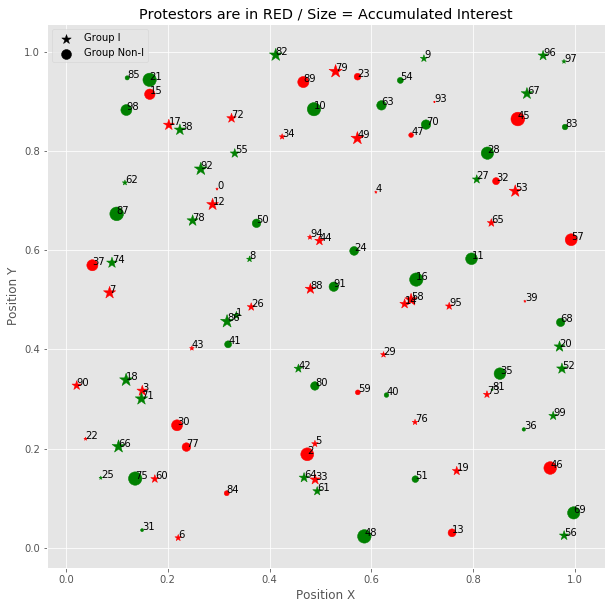

In [5]:
protest = model(N = 100)
protest.draw()

[0.48896522 0.32650692]


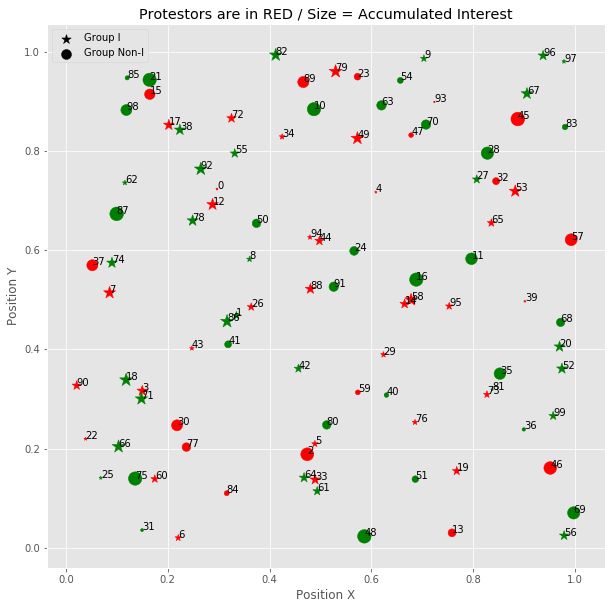

[0.51223131 0.24805152]


In [6]:
k = 80
print(protest.population[k].position)
for i in range(100):
    protest.population[k].move()
protest.draw()
print(protest.population[k].position)

In [7]:
protest.data.head()

,Agent ID,Identity,Prejudice,Accumulated Interest,State,Position X,Position Y,Interest Decay,Interest Growth,Protestor Threshold
0,0,Group I,1,0.034411,Protest,0.296742,0.723082,0.008119,0.008119,0.337448
1,1,Group I,1,0.365237,Non Protest,0.334756,0.468273,0.000336,0.000336,0.736573
2,2,Group Non-I,1,0.830296,Protest,0.473995,0.188901,0.001364,0.001364,0.310954
3,3,Group I,1,0.629671,Protest,0.149981,0.316695,0.009929,0.009929,0.974419
4,4,Group I,0,0.034754,Protest,0.608688,0.716741,0.006830,0.006830,0.040291


# Run Simulation

In [8]:
protest = model(N = 100, time = 1000)
protest.run()

tick number 0 over 1000
tick number 100 over 1000
tick number 200 over 1000
tick number 300 over 1000
tick number 400 over 1000
tick number 500 over 1000
tick number 600 over 1000
tick number 700 over 1000
tick number 800 over 1000
tick number 900 over 1000


In [16]:
protest.population_over_time[0].State.value_counts()

Protest        53
Non Protest    47
Name: State, dtype: int64

In [17]:
protest.population_over_time[2].State.value_counts()

Non Protest    62
Protest        38
Name: State, dtype: int64

In [18]:
protest.population_over_time[0].head()

,Agent ID,Identity,Prejudice,Accumulated Interest,State,Position X,Position Y,Interest Decay,Interest Growth,Protestor Threshold
0,0,Group Non-I,1,0.922303,Non Protest,0.928530,0.194038,0.001541,0.001541,0.017183
1,1,Group I,0,0.543854,Protest,0.040024,0.978880,0.006509,0.006509,0.983422
2,2,Group I,1,0.364459,Protest,0.259298,0.818938,0.006528,0.006528,0.788732
3,3,Group I,0,0.753568,Protest,0.407162,0.105518,0.001608,0.001608,0.977549
4,4,Group Non-I,0,0.442386,Protest,0.864752,0.298663,0.009816,0.009816,0.070379


In [19]:
protest.population_over_time[2].head()

,Agent ID,Identity,Prejudice,Accumulated Interest,State,Position X,Position Y,Interest Decay,Interest Growth,Protestor Threshold
0,0,Group Non-I,1,0.766673,Protest,0.904251,0.197763,0.001541,0.001541,0.017183
1,1,Group I,0,0.120743,Non Protest,0.155941,0.920740,0.006509,0.006509,0.983422
2,2,Group I,1,0.000000,Non Protest,0.259040,0.769181,0.006528,0.006528,0.788732
3,3,Group I,0,0.591122,Non Protest,0.400571,0.042101,0.001608,0.001608,0.977549
4,4,Group Non-I,0,0.000000,Non Protest,0.888397,0.331569,0.009816,0.009816,0.070379


In [20]:
protest.population_over_time[2].columns

Index(['Agent ID', 'Identity', 'Prejudice', 'Accumulated Interest', 'State',
       'Position X', 'Position Y', 'Interest Decay', 'Interest Growth',
       'Protestor Threshold'],
      dtype='object')

In [21]:
protestors = [df.State.value_counts()['Protest']/100 for df in protest.population_over_time]
Identities = [df.Identity.value_counts()['Group I'] for df in protest.population_over_time]
Interests_mean = [df['Accumulated Interest'].mean() for df in protest.population_over_time] 
Interests_std = [df['Accumulated Interest'].std() for df in protest.population_over_time] 

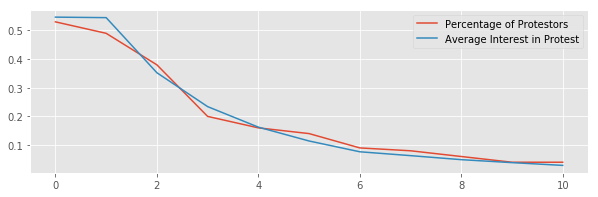

In [22]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(protestors, label = 'Percentage of Protestors')
plt.plot(Interests_mean, label = 'Average Interest in Protest')
#plt.plot(np.array(Interests_mean) + np.array(Interests_std), label = '')
#plt.plot(np.array(Interests_mean) - np.array(Interests_std), label = '')
plt.legend()

# To do

## A more complex model
 - Protesto bir gruptan digerine sicrar mi?
 - Konu (Gezide cevre vb) ya da gruptan dolayi protesto baslar mi?
 
## Details of the more complex model
 - Mobilization: I grubunda A konusu hakkinda bir protesto baslamis olsun. 1) I grubunda A konusuna ilgi duyanlar protestoya katilir. 2) I grubunda A konusuna ilgisi olmayanlar, A konusuna ilgi gelistirirse protestoya katilir __YA DA diger gruptan insanlar I kimligine onyargida bulunursa katilir.__ 3) Diger gruptan A konusuna ilgi duyan VE onyargisi olmayanlar katilir. 4) diger gruptan A konusuna ilgi duyan ama onyargisi olanlar katilmaz. 5) Diger gruptan onyargisi olmayan ama A konusuna ilgi duymayanlar ilgi gelistirirlerse protestoya katilirlar.